# Entropy in Presidential Speeches over the years

This is an Information Theory Project about entropy in Presidental Speeches from USA over the years 

**Methods:**

Entropy Calculation (Shannon Entropy)

Jensen Shannon Dywergention

Latent Dirichlet Allocation

**Main point:** 
Clustering Presidental Speeches based on words 


In [21]:
%pip install nltk==3.8.1

Note: you may need to restart the kernel to use updated packages.


In [22]:
# All imports
import json, requests
import nltk
from nltk.probability import FreqDist
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter, defaultdict
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [23]:
#Importing the data, 1057 speeches 


endpoint = "https://api.millercenter.org/speeches"
out_file = "speeches.json"

r = requests.get(url=endpoint)
data = r.json()
items = data["Items"] # list of speeches

while 'LastEvaluatedKey' in data:
    parameters = {"LastEvaluatedKey": data['LastEvaluatedKey']['doc_name']}
    r = requests.post(url = endpoint, params = parameters)
    data = r.json()
    items += data['Items']
    print(f'{len(items)} speeches')

with open(out_file, "w") as out:
    out.write(json.dumps(items))
    print(f'wrote results to file: {out_file}')



95 speeches
137 speeches
175 speeches
233 speeches
274 speeches
327 speeches
370 speeches
412 speeches
458 speeches
504 speeches
548 speeches
592 speeches
623 speeches
667 speeches
713 speeches
767 speeches
804 speeches
849 speeches
899 speeches
928 speeches
981 speeches
1037 speeches
1058 speeches
wrote results to file: speeches.json


In [24]:
data

{'Items': [{'doc_name': 'december-2-1851-second-annual-message',
   'date': '1851-12-02',
   'transcript': 'Fellow-Citizens of the Senate and of the House of Representatives:\nI congratulate you and our common constituency upon the favorable auspices under which you meet for your first session. Our country is at peace with all the world. The agitation which for a time threatened to disturb the fraternal relations which make us one people is fast subsiding, and a year of general prosperity and health has crowned the nation with unusual blessings. None can look back to the dangers which are passed or forward to the bright prospect before us without feeling a thrill of gratification, at the same time that he must be impressed with a grateful sense of our profound obligations to a beneficent Providence, whose paternal care is so manifest in the happiness of this highly favored land.\nSince the close of the last Congress certain Cubans and other foreigners resident in the United States, who

In [25]:
# Entropy calculation function using frequency distribution of words and Shannon entropy formula
#ADDED NORMALIZATION 

def calculate_entropy(text):
  """Calculates Shannon entropy of a text."""
  tokens = nltk.word_tokenize(text)
  freq_dist = FreqDist(tokens)
  probs = [freq / len(tokens) for freq in freq_dist.values()]
  entropy = -sum(p * math.log(p, 2) for p in probs if p > 0)
  n_words = len(text.split())
  normalized_entropy = entropy / math.log2(n_words)
  return normalized_entropy

In [26]:


# Extracting the text from the json file
speeches = []
for item in items:


    speeches.append(item['transcript'])

# Check Calculating the entropy of the first two speeches
entropy = []
for speech in speeches[:2]:
    entropy.append(calculate_entropy(speech))

entropy
#[0.6914330022996619, 0.7153467589686794]


[0.6914330022996619, 0.7153467589686794]

In [27]:
# Last speech avaialble
latest_speech = max(items, key=lambda x: x['date'])
print(latest_speech['president'], latest_speech['date'])

Joe Biden 2025-01-15T20:00:00-05:00


In [28]:
# Average Entropy of all speeches

entropy = []
for speech in speeches:
    entropy.append(calculate_entropy(speech))
average_entropy = sum(entropy) / len(entropy)
average_entropy


0.7099170687766054

In [29]:
# Average Entropy for each president

presidents = []
for item in items:
    presidents.append(item['president'])

presidents = list(set(presidents))
president_entropy = {president: [] for president in presidents}
for item in items:
    president_entropy[item['president']].append(calculate_entropy(item['transcript']))
    

average_president_entropy = {president: sum(entropy) / len(entropy) for president, entropy in president_entropy.items()}
average_president_entropy


{'Franklin D. Roosevelt': 0.7217722561072746,
 'Bill Clinton': 0.7117802410078573,
 'Abraham Lincoln': 0.6924772269322841,
 'Lyndon B. Johnson': 0.7052281516239124,
 'Harry S. Truman': 0.7268369008665281,
 'Andrew Jackson': 0.6764997534829974,
 'John Quincy Adams': 0.7078545348388979,
 'Ulysses S. Grant': 0.7126860480382601,
 'George H. W. Bush': 0.7102749622387574,
 'Warren G. Harding': 0.769234609043576,
 'James Madison': 0.7320494800581018,
 'James K. Polk': 0.7099402112100661,
 'James Monroe': 0.6670443423273069,
 'William Harrison': 0.6374943105549343,
 'Thomas Jefferson': 0.7314451086807674,
 'George W. Bush': 0.7278714971187203,
 'William Taft': 0.6704294622068855,
 'Herbert Hoover': 0.7337258202247668,
 'William McKinley': 0.7098305854166139,
 'Rutherford B. Hayes': 0.693895452600774,
 'Ronald Reagan': 0.7193864735501591,
 'John F. Kennedy': 0.7153598046990677,
 'Richard M. Nixon': 0.7085430597050933,
 'Calvin Coolidge': 0.6878760855614471,
 'James A. Garfield': 0.7047853647439

In [30]:
# Average Entropy for each year 

years = []
for item in items:
    years.append(item['date'][:4])

years = list(set(years))
year_entropy = {year: [] for year in years}
for item in items:
    year_entropy[item['date'][:4]].append(calculate_entropy(item['transcript']))

average_year_entropy = {year: sum(entropy) / len(entropy) for year, entropy in year_entropy.items()}

sorted_years = sorted(average_year_entropy.keys())

sorted_average_entropy = {year: average_year_entropy[year] for year in sorted_years}
sorted_average_entropy


{'1789': 0.7545727364915908,
 '1790': 0.7401117413004158,
 '1791': 0.6923594664674818,
 '1792': 0.7818916298378257,
 '1793': 0.7984445282570584,
 '1794': 0.7232312304426564,
 '1795': 0.7458273162129174,
 '1796': 0.6996214952028623,
 '1797': 0.7037736655942878,
 '1798': 0.7406486071884812,
 '1799': 0.7378926462973232,
 '1800': 0.749836422969856,
 '1801': 0.7253111044241055,
 '1802': 0.770899146978752,
 '1803': 0.7188295652135027,
 '1804': 0.7148396185109467,
 '1805': 0.729194151848367,
 '1806': 0.7302951939550184,
 '1807': 0.7189515321955134,
 '1808': 0.7044376934051904,
 '1809': 0.749876654810714,
 '1810': 0.7246793307463175,
 '1811': 0.7431252776868587,
 '1812': 0.7490644804293725,
 '1813': 0.7294589923977608,
 '1814': 0.7481181356325088,
 '1815': 0.71499890913239,
 '1816': 0.6851577934846693,
 '1817': 0.6935686951486498,
 '1818': 0.6753625106682059,
 '1819': 0.6601512648051139,
 '1820': 0.6855928112389084,
 '1821': 0.7014907674850116,
 '1822': 0.6669142491803592,
 '1823': 0.655252658

In [31]:
# Plotting the graph


# plt.figure(figsize=(20, 10))
# plt.plot(list(sorted_average_entropy.keys()), list(sorted_average_entropy.values()), marker='o', linestyle='-', color='g')
# plt.xlabel('Year')
# plt.ylabel('Average Entropy')
# plt.title('Average Entropy for each year')

# plt.legend()
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xticks(rotation=45)
# plt.grid()

# plt.show()

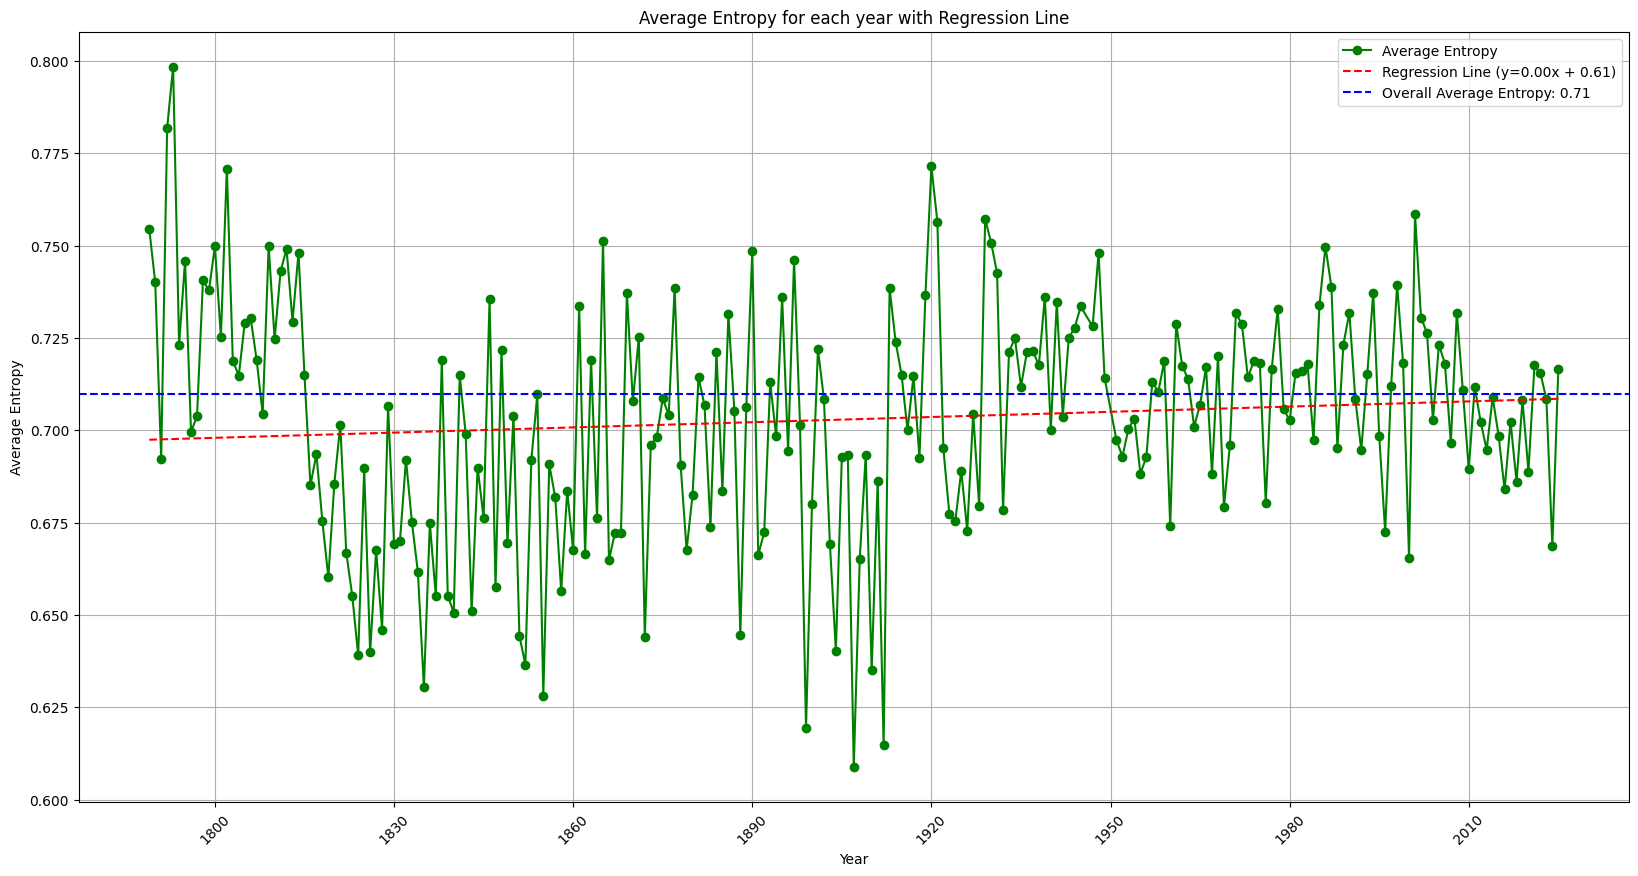

In [32]:
# Plotting the graph with regression line 

years = np.array(list(sorted_average_entropy.keys()), dtype=int)
average_entropy_values = np.array(list(sorted_average_entropy.values()))

slope, intercept = np.polyfit(years, average_entropy_values, 1)
regression_line = slope * years + intercept

plt.figure(figsize=(20, 10))
plt.plot(years, average_entropy_values, marker='o', linestyle='-', color='g', label='Average Entropy')
plt.plot(years, regression_line, color='r', linestyle='--', label=f'Regression Line (y={slope:.2f}x + {intercept:.2f})')
plt.axhline(y=average_entropy, color='b', linestyle='--', label=f'Overall Average Entropy: {average_entropy:.2f}')
plt.xlabel('Year')
plt.ylabel('Average Entropy')
plt.title('Average Entropy for each year with Regression Line')
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.grid()

plt.show()

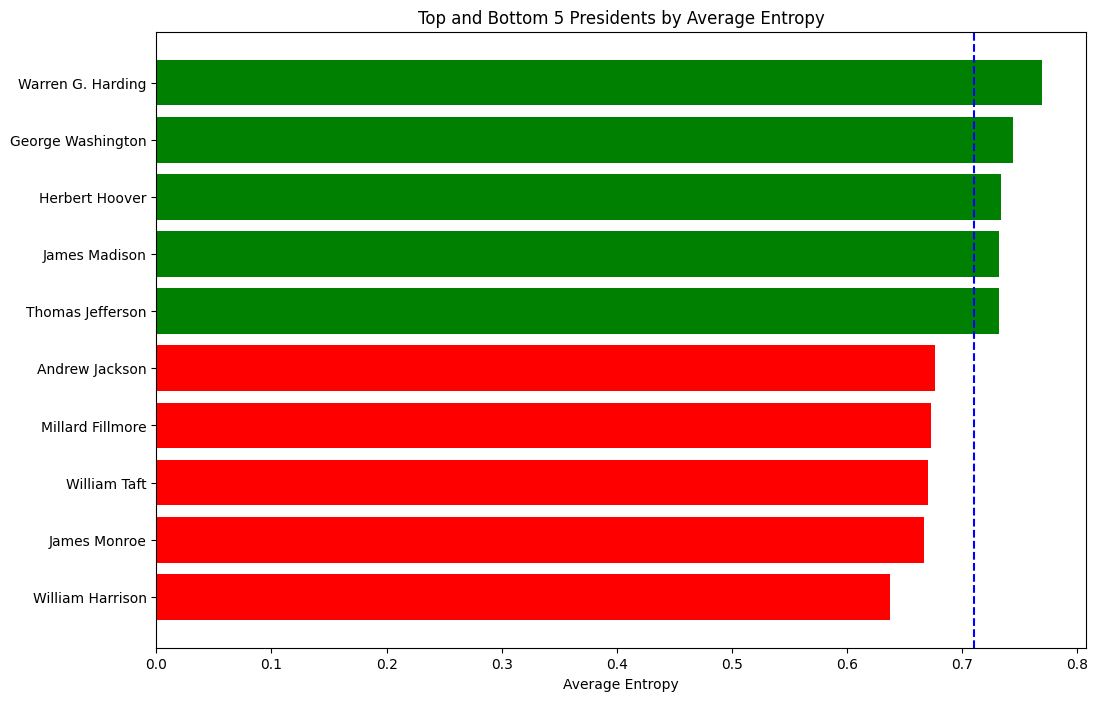

In [33]:


# Top and Bottom 5 Presidents by Average Entropy

sorted_presidents = sorted(average_president_entropy.items(), key=lambda x: x[1])

worst_presidents = sorted_presidents[:5]

best_presidents = sorted_presidents[-5:]

# Combining the two lists for plotting
combined_presidents = worst_presidents + best_presidents

fig, ax = plt.subplots(figsize=(12, 8))
presidents = [president for president, _ in combined_presidents]
entropies = [entropy for _, entropy in combined_presidents]

ax.barh(presidents, entropies, color=['red']*5 + ['green']*5)
ax.axvline(x=average_entropy, color='blue', linestyle='--', label=f'Overall Average Entropy: {average_entropy:.2f}')

ax.set_xlabel('Average Entropy')
ax.set_title('Top and Bottom 5 Presidents by Average Entropy')


plt.show()

*TU CIEKAWSZE* 

*Clustering* 

In [34]:
# To calculate the entropy of a text by words, we need to use always the same alphabet - sample space, which is the set of all unique words in all speeches.

def calculate_word_probabilities(speeches):
    
    all_words = set()
    for speech in speeches:
        all_words.update(speech.split())
    
    all_words = sorted(all_words)
    word_index = {word: i for i, word in enumerate(all_words)}
    
    # Here we calculate the probabilities of each word in each speech using the simplest formula: count(word) / total_words
    probabilities = []
    for speech in speeches:
        word_counts = Counter(speech.split())
        total_words = sum(word_counts.values())
        prob = np.zeros(len(all_words))
        for word, count in word_counts.items():
            prob[word_index[word]] = count / total_words
        probabilities.append(prob)
    
    return np.array(probabilities)

# Calculate the Jensen-Shannon Divergence matrix for the speeches using the probabilities of words
# First we create a null matrix with the size of the number of speeches
# Then we update the matix with the JSD values for each pair of speeches

def calculate_jsd_matrix(probabilities):
    num_speeches = len(probabilities)
    jsd_matrix = np.zeros((num_speeches, num_speeches))
    
    for i in range(num_speeches):
        for j in range(i + 1, num_speeches):
            jsd = jensenshannon(probabilities[i], probabilities[j])
            jsd_matrix[i, j] = jsd
            jsd_matrix[j, i] = jsd
    
    return jsd_matrix

# Cluster the speeches using the KMeans algorithm

def cluster_speeches(jsd_matrix, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(jsd_matrix)
    return clusters



In [35]:

# Clastering speeches
probabilities = calculate_word_probabilities(speeches)
jsd_matrix = calculate_jsd_matrix(probabilities)
num_clusters = 5
clusters = cluster_speeches(jsd_matrix, num_clusters)

# Results
for i, cluster in enumerate(clusters):
    print(f"Speech {i+1} is in cluster {cluster}")

Speech 1 is in cluster 3
Speech 2 is in cluster 3
Speech 3 is in cluster 0
Speech 4 is in cluster 4
Speech 5 is in cluster 3
Speech 6 is in cluster 1
Speech 7 is in cluster 4
Speech 8 is in cluster 4
Speech 9 is in cluster 0
Speech 10 is in cluster 1
Speech 11 is in cluster 2
Speech 12 is in cluster 1
Speech 13 is in cluster 4
Speech 14 is in cluster 3
Speech 15 is in cluster 3
Speech 16 is in cluster 4
Speech 17 is in cluster 3
Speech 18 is in cluster 4
Speech 19 is in cluster 4
Speech 20 is in cluster 4
Speech 21 is in cluster 2
Speech 22 is in cluster 4
Speech 23 is in cluster 0
Speech 24 is in cluster 4
Speech 25 is in cluster 2
Speech 26 is in cluster 3
Speech 27 is in cluster 4
Speech 28 is in cluster 3
Speech 29 is in cluster 1
Speech 30 is in cluster 0
Speech 31 is in cluster 0
Speech 32 is in cluster 0
Speech 33 is in cluster 3
Speech 34 is in cluster 1
Speech 35 is in cluster 3
Speech 36 is in cluster 4
Speech 37 is in cluster 1
Speech 38 is in cluster 3
Speech 39 is in clust

In [36]:
# TOP WORDS PER CLUSTER - USELESS

# def get_top_words_per_cluster(speeches, clusters, top_n=10):
#     cluster_words = {}
#     for cluster_id in set(clusters):
#         cluster_speeches = [speeches[i] for i in range(len(speeches)) if clusters[i] == cluster_id]
#         all_words = ' '.join(cluster_speeches).split()
#         word_counts = Counter(all_words)
#         top_words = word_counts.most_common(top_n)
#         cluster_words[cluster_id] = top_words
#     return cluster_words


# top_words_per_cluster = get_top_words_per_cluster(speeches, clusters)


# for cluster_id, top_words in top_words_per_cluster.items():
#     print(f"Klaster {cluster_id}:")
#     for word, count in top_words:
#         print(f"  {word}: {count}")
#     print()

In [37]:
# LDA Analysis for each cluster to obtain the dominant topics in each cluster

def perform_lda_analysis(speeches, clusters, num_topics=5):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(speeches)
    
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-num_topics - 1:-1]]
        topics[topic_idx] = top_features
    
    cluster_topics = {}
    for cluster_id in set(clusters):
        cluster_speeches = [speeches[i] for i in range(len(speeches)) if clusters[i] == cluster_id]
        X_cluster = vectorizer.transform(cluster_speeches)
        topic_distribution = lda.transform(X_cluster)
        dominant_topic = topic_distribution.mean(axis=0).argmax()
        cluster_topics[cluster_id] = topics[dominant_topic]
    
    return cluster_topics


cluster_topics = perform_lda_analysis(speeches, clusters)


for cluster_id, topics in cluster_topics.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Main Topics: {', '.join(topics)}")
    print()

Cluster 0:
  Main Topics: states, united, government, congress, state

Cluster 1:
  Main Topics: world, people, america, american, new

Cluster 2:
  Main Topics: states, united, government, congress, state

Cluster 3:
  Main Topics: states, united, government, congress, state

Cluster 4:
  Main Topics: world, people, america, american, new



In [38]:
# Assign presidents to clusters 
                            
cluster_presidents = defaultdict(list)
for i, cluster in enumerate(clusters):
    if i < len(presidents):
        cluster_presidents[cluster].append(presidents[i])

# Show what presidents are in each cluster 


print("\nPresidents in each cluster:")
for cluster_id in cluster_presidents:
    print(f"Cluster {cluster_id}: {set(cluster_presidents[cluster_id])}")


Presidents in each cluster:
Cluster 3: {'Andrew Jackson', 'James Monroe', 'William Harrison'}
Cluster 0: {'George Washington', 'William Taft'}
Cluster 4: {'James Madison', 'Herbert Hoover', 'Millard Fillmore'}
Cluster 1: {'Warren G. Harding', 'Thomas Jefferson'}


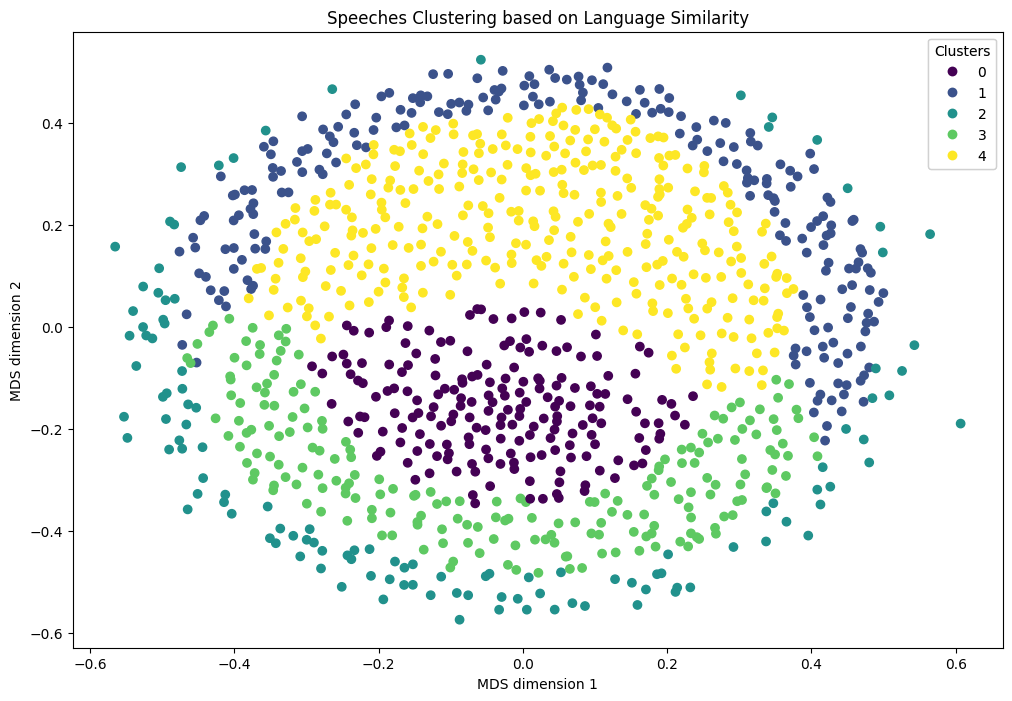

In [39]:
# Import necessary libraries for MDS
from sklearn.manifold import MDS

# Apply MDS to the JSD matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_data = mds.fit_transform(jsd_matrix)

# Creating a scatter plot with clusters and speech numbers
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')

plt.xlabel('MDS dimension 1')
plt.ylabel('MDS dimension 2')
plt.title('Speeches Clustering based on Language Similarity')

legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)

# Description of each point (optional, can be removed if not needed)
# for i, point in enumerate(reduced_data):
#     plt.text(point[0], point[1], str(i+1), fontsize=9, ha='center')

plt.show()

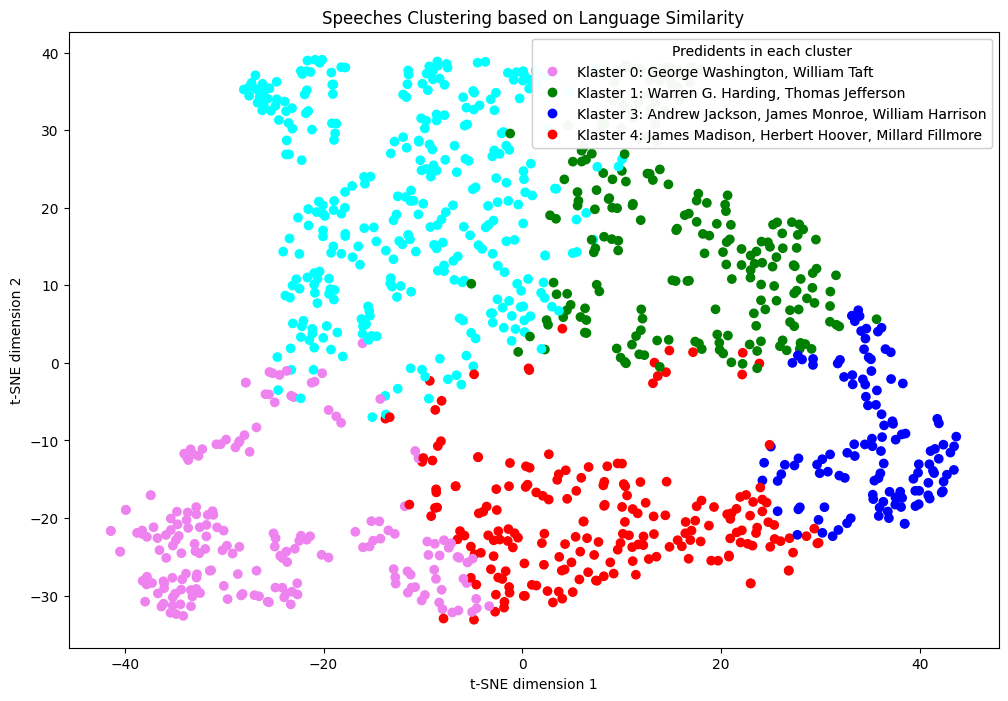

In [40]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors


tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(jsd_matrix)


colors = ['violet', 'green', 'blue', 'red', 'cyan']
cmap = mcolors.ListedColormap(colors)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap=cmap)


plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.title('Speeches Clustering based on Language Similarity')


legend_labels = []
for cluster_id in sorted(cluster_presidents.keys()):
    presidents_in_cluster = ', '.join(set(cluster_presidents[cluster_id]))
    legend_labels.append(f"Klaster {cluster_id}: {presidents_in_cluster}")

handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, legend_labels, loc="upper right", title="Predidents in each cluster")
plt.gca().add_artist(legend1)

# No Need - useless
#for i, point in enumerate(reduced_data):
#    plt.text(point[0], point[1], str(i+1), fontsize=9, ha='center')

plt.show()

## The linguistic style of the presidents has evolved over time but still nowadays speeches are similar to old ones. 

This phenomenon can be observed in the regression graph, which illustrates that the average entropy has increased over time.
It is unclear whether this is related to the presidents themselves, the language of speech at the time, or other factors.
For example, changes in culture and technology may be relevant. Two hundred years ago, the topic of social media did not exist, whereas today it is one of the most important subjects.
In contrast, the subjects of war, oil, energy and warfare have consistently been subjects of discussion.

#### Our findings indicate that the *average entropy has increased over time*, although this is not attributable to the presidents themselves, but rather to other factors.
#### Presidential Speeches can be categorized over the years based on word similarity, it shows that no matter of time speeches are similar over the various times 

# THE END 
# Wiktoria Domańska
# Filip Niewczas